# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [30]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [31]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [32]:
# Define the directories that contain the files downloaded
dir_cs = os.getcwd() + "/1805_download" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file =  "./clean_data.pickle" # path to save cleaned data

In [33]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'installment','annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
              'fico_range_high', 'fico_range_low','revol_bal','total_pymnt','recoveries']
cat_cols = ['term','grade', 'emp_length','home_ownership','verification_status', 'loan_status', 'purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [34]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [35]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory =  directory + "/"
    all_files = []
    for file in os.listdir(directory):
        if file.endswith(".zip"):
            all_files.append(file)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype='str', header=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        l = output[i]['id'].tolist()
        invalid_rows = [x for x, y in enumerate(l) if not is_integer(y)]# mask rows that have non-integer IDs. Use is_integer method
        if len(invalid_rows) != 0:
            print("Found " + str(len(invalid_rows)) + " invalid rows which were removed")
            output[i].drop(output[i].index[invalid_rows])
    
    return output # return dictionary of dataframe

In [36]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory C:\Users\Wenting Zhao\Documents\ML\case study\Phase 2/1805_download/ has 12 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file 

### Combine the files

In [37]:
li = []
for key, value in files_cs.items():
    li.append(value)
data_cs = pd.concat(li, ignore_index=True) # combine "files_cs" into a pandas dataframe
              # resent index with drop = True

## Prepare Final Dataset

In [38]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[data_cs.columns[data_cs.columns.isin(cols_to_pick)]]


In [39]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765451 rows


### Typecast the columns

In [40]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype('float') # typecast float columns

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
for i in cat_cols:
    final_data[i] = final_data[i].replace(np.nan, None, regex=True)
    final_data[i] = final_data[i].replace(r'\s+', None, regex=True,)# for categorical features if the value is null/empty set it to None

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Calculate returns for each loan

In [44]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [45]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

loan_length_greater_than_0 = final_data['loan_length'] != 0
final_data = final_data[loan_length_greater_than_0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Removed 6218 rows


### M1-Pessimistic Method

In [46]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / 
                          final_data['funded_amnt']) * (12 / final_data['term_num'])

### M2-Optimistic Method

In [47]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / 
                          final_data['funded_amnt']) * (12 / round(final_data['loan_length']))

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / 
                          final_data['funded_amnt']) * (12 / final_data['term_num'])

### Method 3

In [48]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) /final_data.term_num

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment* (1-(1+i/12)**final_data.term_num)/(1-(1+i/12)) # compute the quantity given in [] in eq.2.3 of handout
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - round(final_data['loan_length'])
    final_return = cash_by_end_of_loan *((1+i/12)**remaining_months)

    # Find the percentage return
    ret_val = (12/T) * (final_return-final_data['funded_amnt'])/final_data['funded_amnt']
    return ret_val

In [49]:
final_data['ret_INTa'] = ret_method_3(60,0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60,0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [50]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(set(final_data[i]),reverse=True)[0:3] # get 3 highest values
        
        smallest_val = min(final_data[i])
        print("The smallest value is:" + str(smallest_val))
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [51]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print("field name:"+i) # print field name
        print("number of distinct values:"+str(len(set(final_data[i]))))# print number of distinct values
        for d in set(final_data[i]):
            print(d+" occurs "+str((final_data[i] == d).sum())+" times")# for each distinct value print the number of occurances
        print("")
        print("")

In [52]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

The smallest value is:500.0


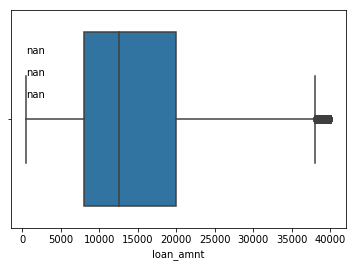

The smallest value is:500.0


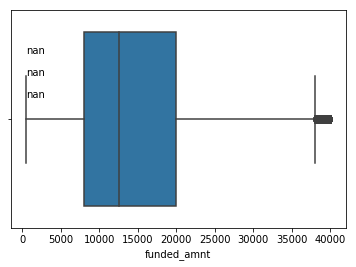

The smallest value is:4.93


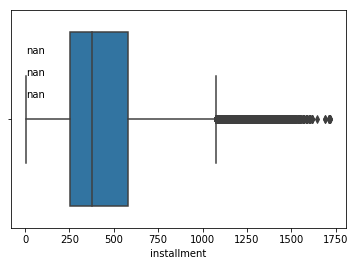

The smallest value is:0.0


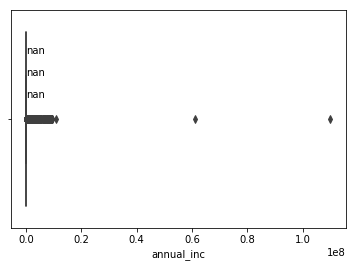

The smallest value is:-1.0


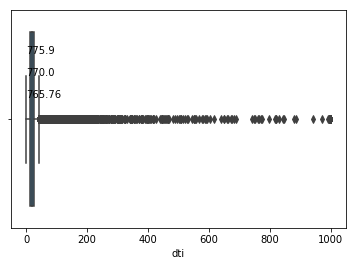

The smallest value is:0.0


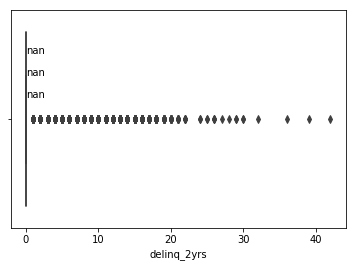

The smallest value is:0.0


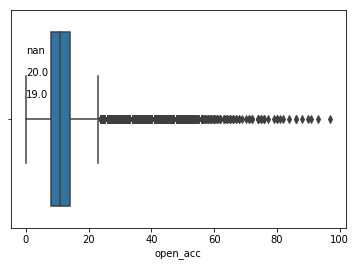

The smallest value is:0.0


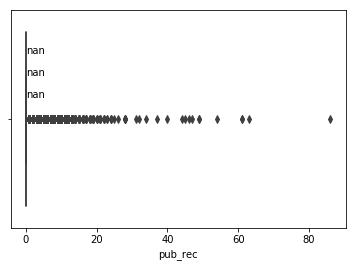

The smallest value is:614.0


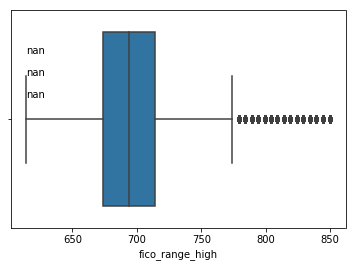

The smallest value is:610.0


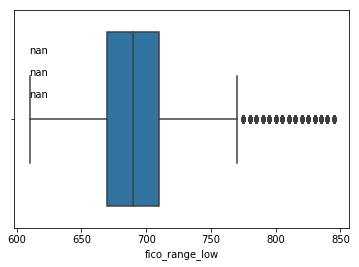

The smallest value is:0.0


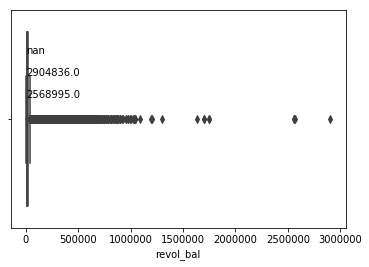

The smallest value is:0.0


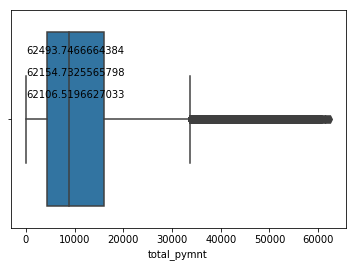

The smallest value is:0.0


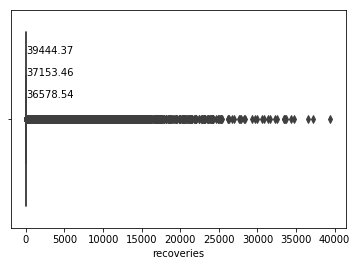

The smallest value is:5.32


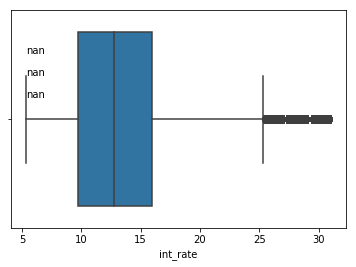

The smallest value is:0.0


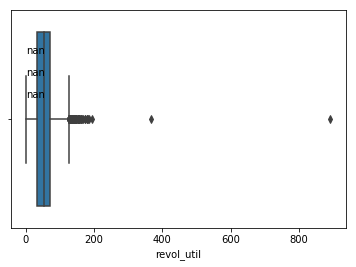

The smallest value is:-0.3333333333333333


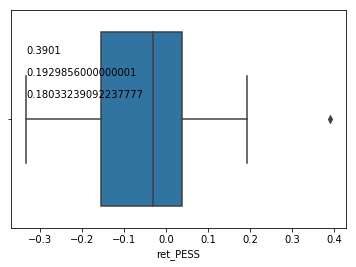

The smallest value is:-0.33317542857142857


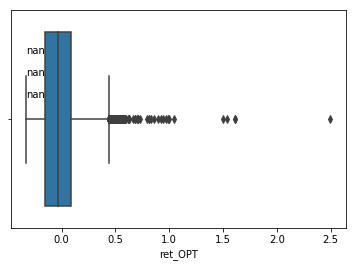

The smallest value is:-0.19996594885464575


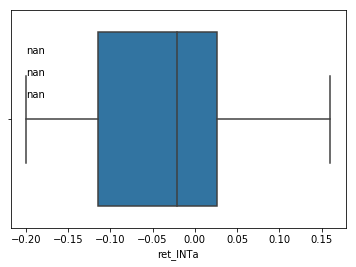

The smallest value is:-0.19996528104928607


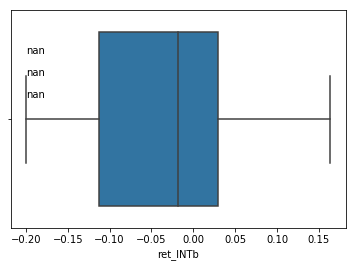

field name:term
number of distinct values:2
 36 months occurs 1260623 times
 60 months occurs 498610 times


field name:grade
number of distinct values:7
D occurs 254394 times
F occurs 38426 times
B occurs 520533 times
E occurs 116177 times
C occurs 521321 times
A occurs 296998 times
G occurs 11384 times


field name:emp_length
number of distinct values:11
3 years occurs 148453 times
6 years occurs 85413 times
4 years occurs 111680 times
5 years occurs 115152 times
9 years occurs 70661 times
< 1 year occurs 155376 times
10+ years occurs 622678 times
1 year occurs 122177 times
8 years occurs 80388 times
7 years occurs 78876 times
2 years occurs 168379 times


field name:home_ownership
number of distinct values:6
MORTGAGE occurs 869379 times
ANY occurs 504 times
OWN occurs 191889 times
OTHER occurs 182 times
RENT occurs 697225 times
NONE occurs 54 times


field name:verification_status
number of distinct values:3
Verified occurs 529109 times
Source Verified occurs 668300 times
Not Verifi

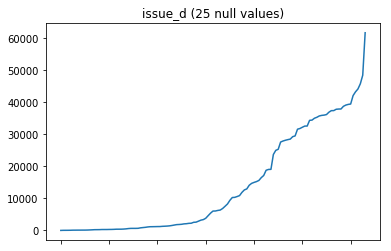

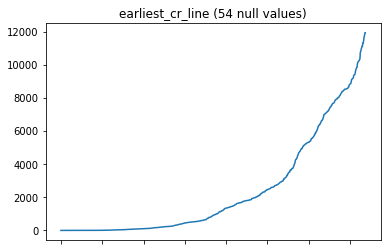

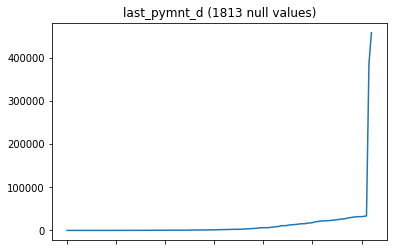

In [53]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [54]:
### There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

final_data = final_data[final_data['loan_amnt']<38000] # remove outliers based 1st obvious feature
final_data = final_data[final_data['funded_amnt']<38000] # remove outliers based 2nd obvious feature
final_data = final_data[final_data['installment']<1100]
final_data = final_data[final_data['annual_inc']<200000]
final_data = final_data[final_data['dti']<50]
final_data = final_data[final_data['open_acc']<25]
final_data = final_data[final_data['revol_bal']<100000]
final_data = final_data[final_data['fico_range_high']<780]
final_data = final_data[final_data['fico_range_low']<770]
final_data = final_data[final_data['revol_util']<150]

# remove outliers based kth obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 215729 rows


Based on the boxplot and our intuition:
'loan_amnt','funded_amnt','installment','annual_inc','dti','open_acc','fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util' These variables are easily seperated, so we exclude the outliners by eyeballing and our common sense.
Other variables cannot be seperated by eyeballing. Moreover, we tried to change them but found out we excluded too many instances from grade E,F,G and caused the dataset to be unbalanced.

In [55]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status']!='Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 682329 rows


In [56]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data['issue_d']>=datetime.date(2010, 1, 1) ]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 7181 rows


### Drop null values

In [57]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

for i in required_cols:
    final_data=final_data[pd.notnull(final_data[i])]# drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1445 rows


### Visualize clean data

The smallest value is:1000.0


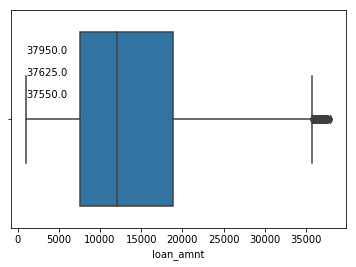

The smallest value is:1000.0


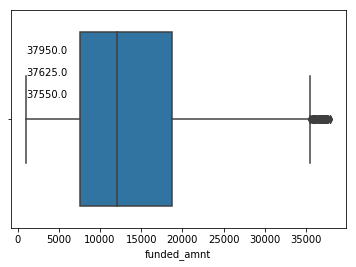

The smallest value is:4.93


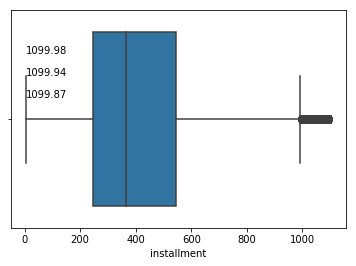

The smallest value is:600.0


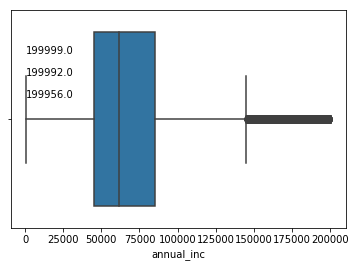

The smallest value is:-1.0


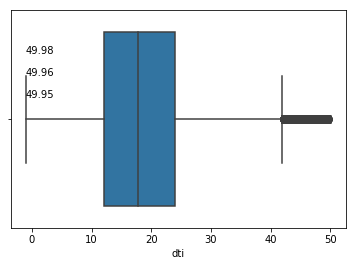

The smallest value is:0.0


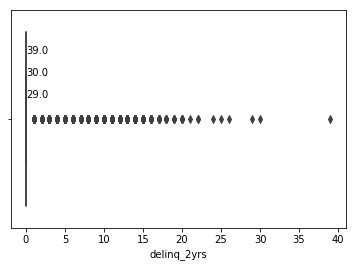

The smallest value is:1.0


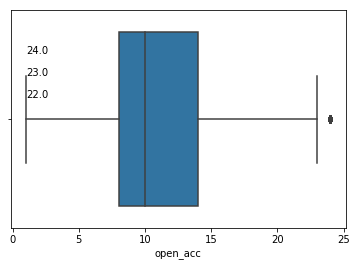

The smallest value is:0.0


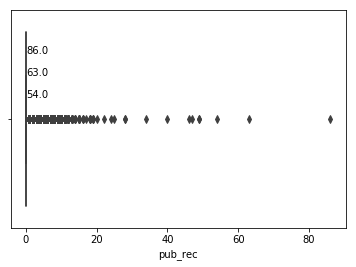

The smallest value is:664.0


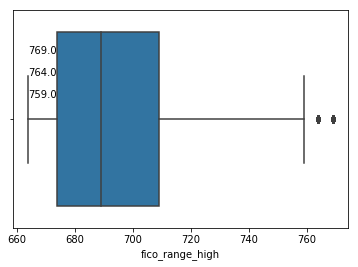

The smallest value is:660.0


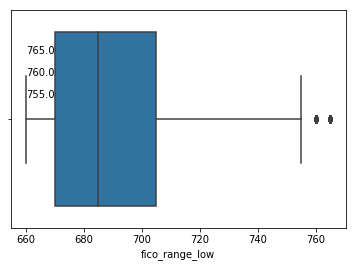

The smallest value is:0.0


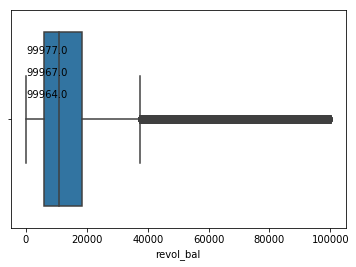

The smallest value is:5.0


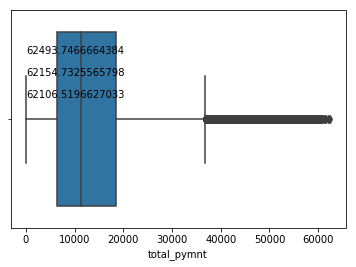

The smallest value is:0.0


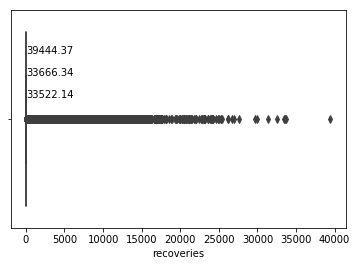

The smallest value is:5.32


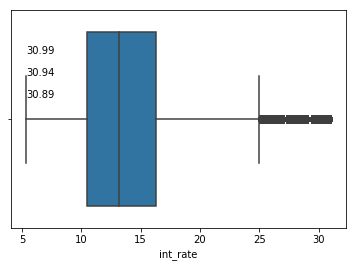

The smallest value is:0.0


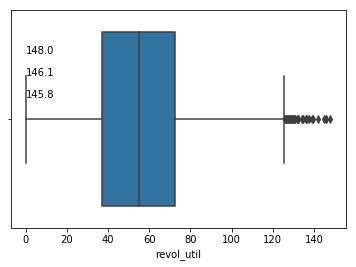

The smallest value is:-0.33296296296296296


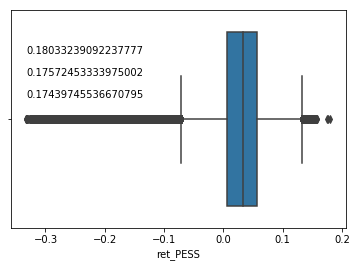

The smallest value is:-0.33296296296296296


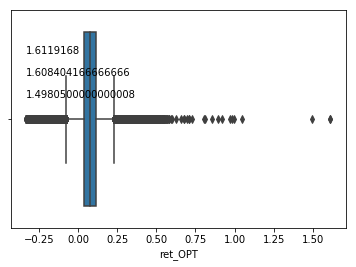

The smallest value is:-0.19996594885464575


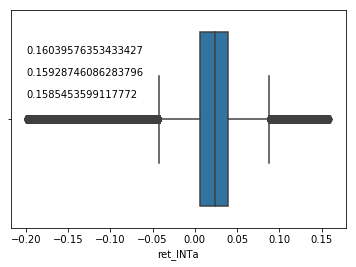

The smallest value is:-0.19996528104928607


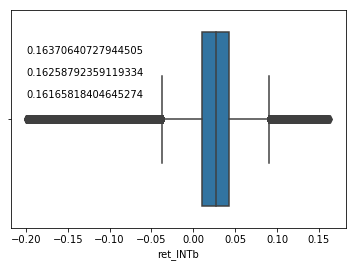

field name:term
number of distinct values:2
 36 months occurs 638505 times
 60 months occurs 214044 times


field name:grade
number of distinct values:7
D occurs 136797 times
F occurs 24407 times
B occurs 248267 times
E occurs 67458 times
C occurs 246911 times
A occurs 122285 times
G occurs 6424 times


field name:emp_length
number of distinct values:11
3 years occurs 72357 times
6 years occurs 43998 times
4 years occurs 54348 times
5 years occurs 57277 times
9 years occurs 35049 times
< 1 year occurs 71583 times
10+ years occurs 291310 times
1 year occurs 59564 times
8 years occurs 42570 times
7 years occurs 42566 times
2 years occurs 81927 times


field name:home_ownership
number of distinct values:6
MORTGAGE occurs 410389 times
ANY occurs 119 times
OWN occurs 86540 times
OTHER occurs 48 times
RENT occurs 355412 times
NONE occurs 41 times


field name:verification_status
number of distinct values:3
Verified occurs 272121 times
Source Verified occurs 316785 times
Not Verified occurs 2

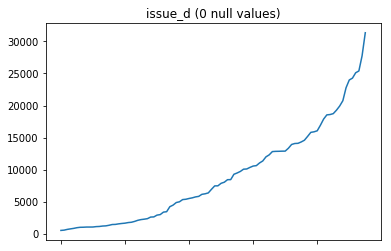

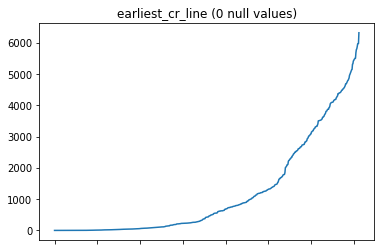

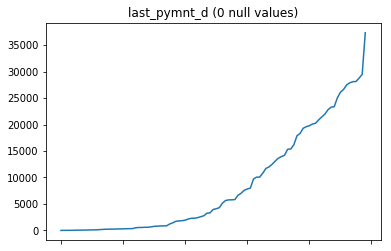

In [58]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

In [59]:
cols = ['term','grade', 'emp_length','home_ownership','verification_status', 'purpose']
tmp = pd.get_dummies(final_data, columns = cols).drop('loan_status', axis=1)
tmp2 = pd.get_dummies(final_data, columns = cat_cols)

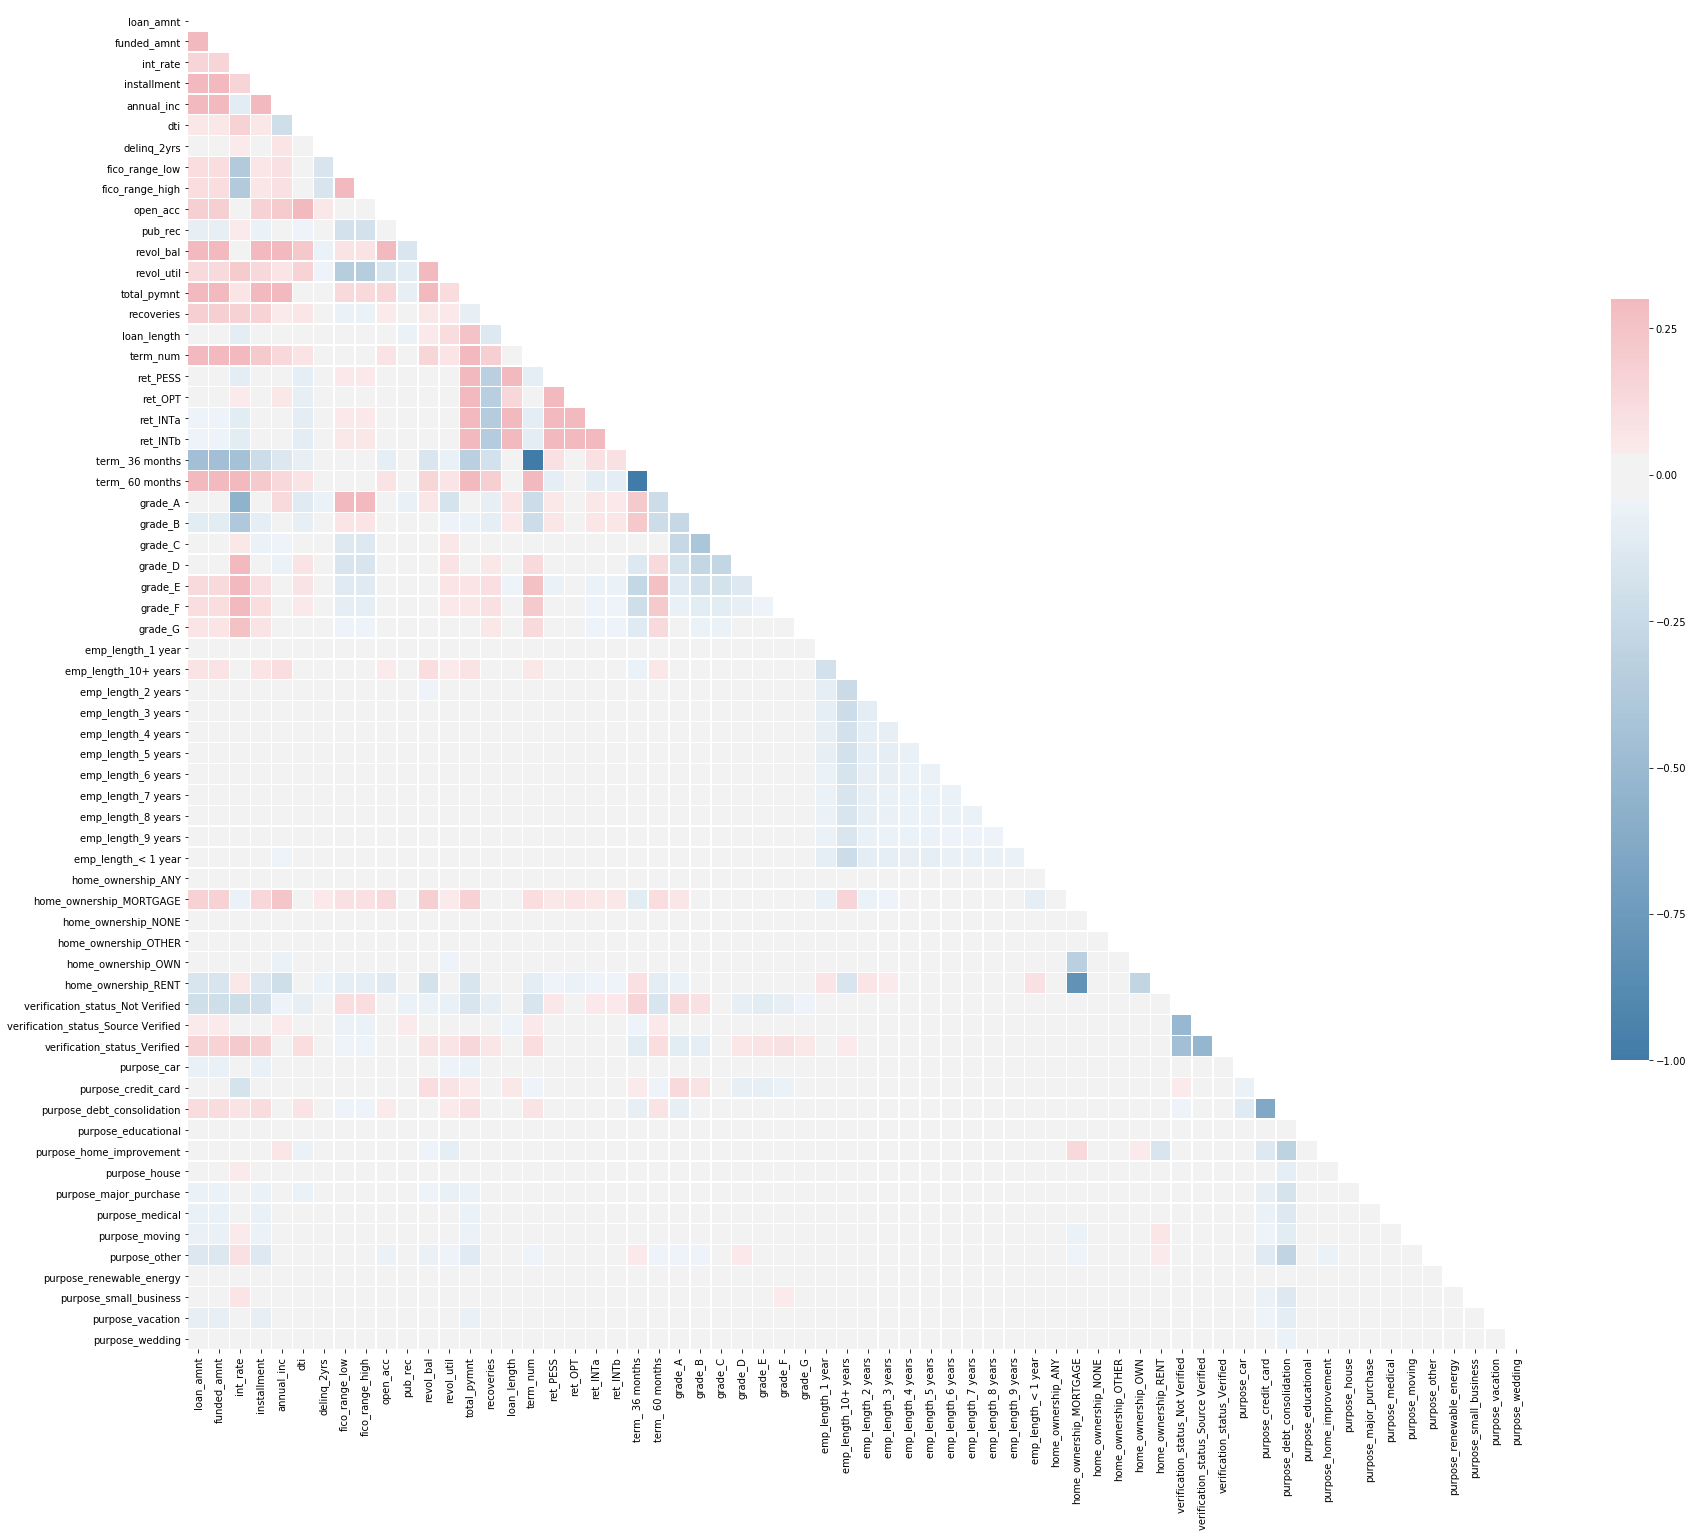

In [60]:
# Visualize the feature correlations
 # use sns scatter or pairplot

# Compute the correlation matrix
corr = tmp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 28))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [61]:
tmp2.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'int_rate', 'installment',
       'annual_inc', 'issue_d', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_pymnt', 'recoveries', 'last_pymnt_d',
       'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa',
       'ret_INTb', 'term_ 36 months', 'term_ 60 months', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Sour

In [62]:
selected = ['loan_status_Charged Off', 'loan_status_Default',
       'loan_status_Does not meet the credit policy. Status:Charged Off',
       'loan_status_Does not meet the credit policy. Status:Fully Paid',
       'loan_status_Fully Paid', 'loan_status_In Grace Period',
       'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']

In [63]:
tmp2.columns.difference(selected)

Index(['annual_inc', 'delinq_2yrs', 'dti', 'earliest_cr_line',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year', 'fico_range_high',
       'fico_range_low', 'funded_amnt', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'id', 'installment', 'int_rate', 'issue_d', 'last_pymnt_d', 'loan_amnt',
       'loan_length', 'open_acc', 'pub_rec', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other'

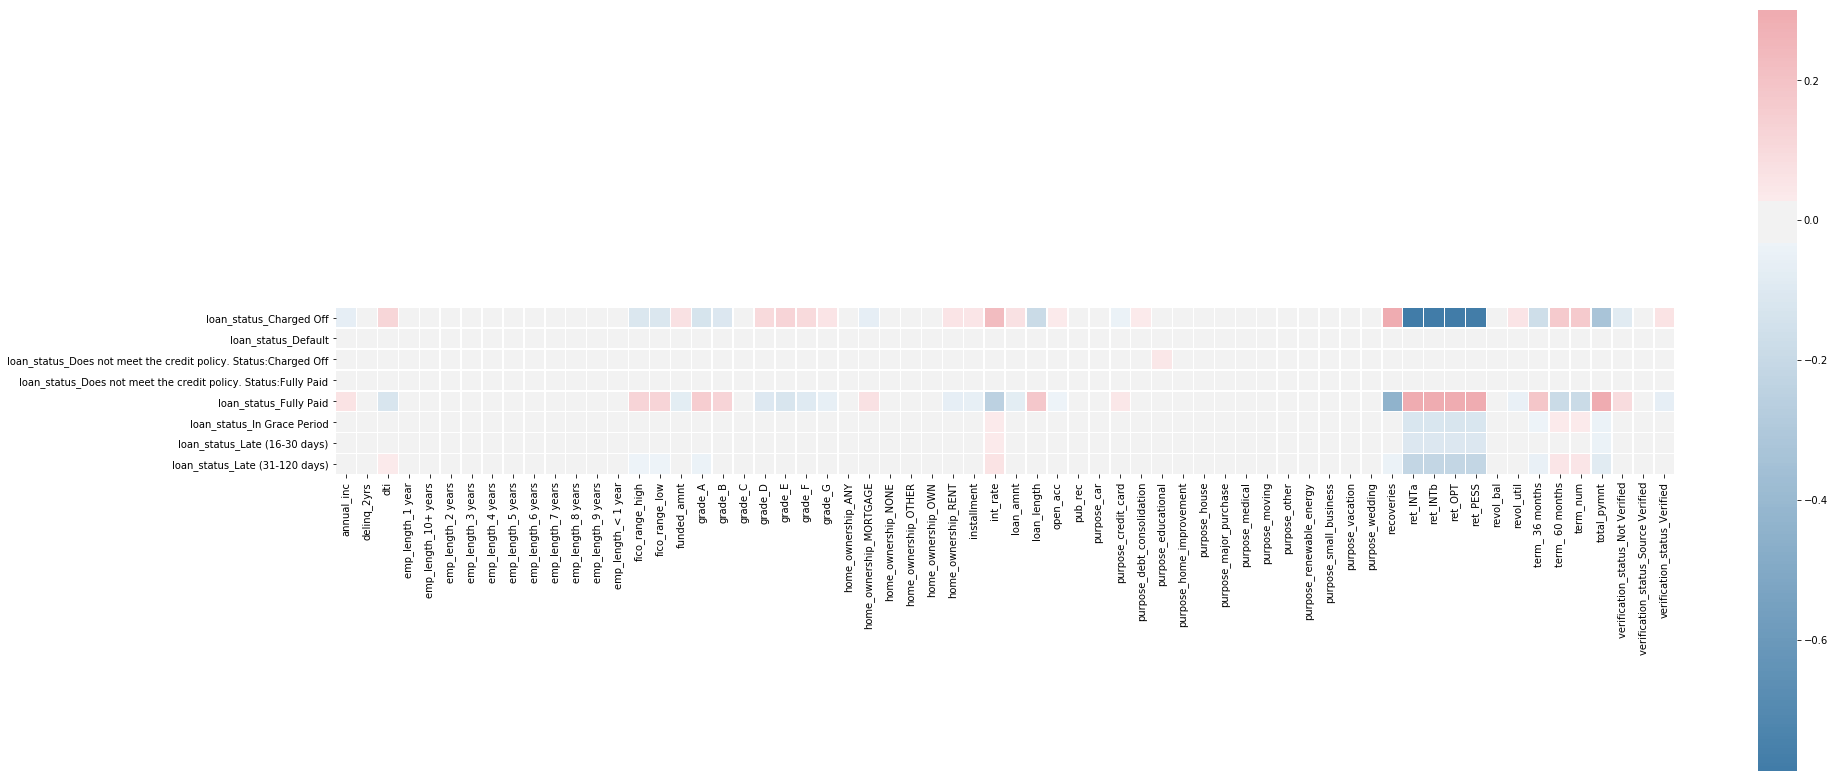

In [64]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations
# Compute the correlation matrix
corr2 = tmp2.corr()



# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 28))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr2.loc[selected][corr2.columns.difference(selected)],  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

What do you observe after removing the outliers?**Answer:**

### Data Exploration
Solution to Q.7 from the handout

In [65]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)) # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)) # average return for M3
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate)) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_PESS'] = 100*ret_by_grade_PESS
combined['return_OPT'] = 100*ret_by_grade_OPT
combined['return_INTa'] = 100*ret_by_grade_INTa
combined['return_INTb'] = 100*ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_PESS,return_OPT,return_INTa,return_INTb
A,14.343457,8.081940,7.330091,1.477445,3.611937,1.082055,1.374830
B,29.120555,15.924388,10.870114,1.211158,4.497838,0.929559,1.228255
C,28.961503,26.173804,14.078565,0.035240,4.567171,0.155440,0.456917
D,16.045647,34.219318,17.560877,-0.486402,4.858274,-0.276373,0.022685
E,7.912507,42.865190,20.781932,-1.347226,5.081852,-1.026336,-0.724677
F,2.862827,48.842545,24.519123,-1.760550,5.579841,-1.482587,-1.181239
G,0.753505,54.000623,27.184958,-3.323352,5.026508,-2.750879,-2.455955


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [66]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = [e for e in continuous_features if e not in('total_pymnt','recoveries')]

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?**Answer:**Because these two variables are not useful for future prediction. They will not show up in the future datasets, since the new loan do not have 'total_pymt' and 'recoveries'.

In [67]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )